In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from pathlib import Path

In [3]:
def load_multiple_json_files(folder_path):
    """
    Load multiple JSON files from a folder into a single DataFrame
    """
    all_data = []
    
    # Get all JSON files in the folder
    json_files = list(Path(folder_path).glob('*.json'))
    
    for file_path in json_files:
        try:
            # Read each JSON file
            df = pd.read_json(file_path)
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
    
    # Combine all DataFrames
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        # Convert timestamp to datetime if not already
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
        # Sort by timestamp
        combined_df = combined_df.sort_values('timestamp')
        # Remove duplicates if any
        combined_df = combined_df.drop_duplicates(subset=['timestamp'])
        return combined_df
    else:
        raise ValueError("No data could be loaded from the JSON files")

In [4]:
def load_all_data(weather_folder, pollution_folder):
    """
    Load weather and pollution data from respective folders
    """
    print("Loading weather data...")
    weather_df = load_multiple_json_files(weather_folder)
    print(f"Loaded {len(weather_df)} weather records")
    
    print("\nLoading pollution data...")
    pollution_df = load_multiple_json_files(pollution_folder)
    print(f"Loaded {len(pollution_df)} pollution records")
    
    return weather_df, pollution_df

In [15]:
def time_series_analysis(weather_df, pollution_df):
    """
    Analyze time series with proper handling of non-numeric columns
    """
    # For weather data
    # Drop non-numeric columns except timestamp
    weather_numeric = weather_df.select_dtypes(include=[np.number])
    weather_numeric['timestamp'] = weather_df['timestamp']
    
    # For pollution data
    pollution_numeric = pollution_df.select_dtypes(include=[np.number])
    pollution_numeric['timestamp'] = pollution_df['timestamp']
    
    # Resample data to hourly intervals
    weather_hourly = weather_numeric.set_index('timestamp').resample('h').mean()
    pollution_hourly = pollution_numeric.set_index('timestamp').resample('h').mean()
    
    # Print the columns to verify what we're working with
    print("Weather columns:", weather_hourly.columns.tolist())
    print("Pollution columns:", pollution_hourly.columns.tolist())
    
    # Create subplots for weather parameters
    fig = make_subplots(rows=3, cols=1, subplot_titles=('Temperature', 'Humidity', 'Wind Speed'))
    
    # Add traces only if columns exist
    if 'temperature' in weather_hourly.columns:
        fig.add_trace(go.Scatter(x=weather_hourly.index, y=weather_hourly['temperature'],
                                mode='lines', name='Temperature'), row=1, col=1)
    if 'humidity' in weather_hourly.columns:
        fig.add_trace(go.Scatter(x=weather_hourly.index, y=weather_hourly['humidity'],
                                mode='lines', name='Humidity'), row=2, col=1)
    if 'wind_speed' in weather_hourly.columns:
        fig.add_trace(go.Scatter(x=weather_hourly.index, y=weather_hourly['wind_speed'],
                                mode='lines', name='Wind Speed'), row=3, col=1)
    
    fig.update_layout(height=900, title_text="Weather Parameters Over Time")
    fig.show()
    
    # Create subplots for pollution parameters
    pollution_params = ['aqi', 'co', 'no2', 'o3', 'pm2_5', 'pm10']
    available_params = [param for param in pollution_params if param in pollution_hourly.columns]
    
    if available_params:
        fig = make_subplots(rows=3, cols=2, subplot_titles=tuple(available_params))
        
        positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2)]
        for param, pos in zip(available_params, positions):
            fig.add_trace(go.Scatter(x=pollution_hourly.index, y=pollution_hourly[param],
                                    mode='lines', name=param), row=pos[0], col=pos[1])
        
        fig.update_layout(height=900, title_text="Pollution Parameters Over Time")
        fig.show()

In [6]:
def basic_analysis(weather_df, pollution_df):
    print("Weather Data Overview:")
    print("=====================")
    print(f"Time Range: {weather_df['timestamp'].min()} to {weather_df['timestamp'].max()}")
    print(f"Number of records: {len(weather_df)}")
    print("\nWeather Data Summary:")
    print(weather_df.describe())
    
    print("\nPollution Data Overview:")
    print("=====================")
    print(f"Time Range: {pollution_df['timestamp'].min()} to {pollution_df['timestamp'].max()}")
    print(f"Number of records: {len(pollution_df)}")
    print("\nPollution Data Summary:")
    print(pollution_df.describe())

In [7]:
# 3. Correlation Analysis
def correlation_analysis(weather_df, pollution_df):
    # Merge weather and pollution data
    merged_df = pd.merge_asof(pollution_df.sort_values('timestamp'), 
                             weather_df.sort_values('timestamp'),
                             on='timestamp', 
                             suffixes=('_pollution', '_weather'))
    
    # Calculate correlations
    numerical_cols = merged_df.select_dtypes(include=[np.number]).columns
    corr_matrix = merged_df[numerical_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix: Weather vs Pollution Parameters')
    plt.show()


In [8]:
# 4. Distribution Analysis
def distribution_analysis(weather_df, pollution_df):
    # Weather parameters distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    weather_params = ['temperature', 'humidity', 'pressure', 'wind_speed']
    
    for param, ax in zip(weather_params, axes.ravel()):
        sns.histplot(weather_df[param], kde=True, ax=ax)
        ax.set_title(f'{param} Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Pollution parameters distributions
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    pollution_params = ['aqi', 'co', 'no2', 'o3', 'pm2_5', 'pm10']
    
    for param, ax in zip(pollution_params, axes.ravel()):
        sns.histplot(pollution_df[param], kde=True, ax=ax)
        ax.set_title(f'{param} Distribution')
    
    plt.tight_layout()
    plt.show()


In [9]:
# 5. Seasonal Patterns
def seasonal_analysis(weather_df, pollution_df):
    # Add time components
    weather_df['hour'] = weather_df['timestamp'].dt.hour
    weather_df['month'] = weather_df['timestamp'].dt.month
    
    pollution_df['hour'] = pollution_df['timestamp'].dt.hour
    pollution_df['month'] = pollution_df['timestamp'].dt.month
    
    # Hourly patterns
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    weather_hourly = weather_df.groupby('hour')['temperature'].mean()
    sns.lineplot(data=weather_hourly, ax=axes[0])
    axes[0].set_title('Average Temperature by Hour')
    
    pollution_hourly = pollution_df.groupby('hour')['aqi'].mean()
    sns.lineplot(data=pollution_hourly, ax=axes[1])
    axes[1].set_title('Average AQI by Hour')
    
    plt.tight_layout()
    plt.show()
    
    # Monthly patterns
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    weather_monthly = weather_df.groupby('month')['temperature'].mean()
    sns.lineplot(data=weather_monthly, ax=axes[0])
    axes[0].set_title('Average Temperature by Month')
    
    pollution_monthly = pollution_df.groupby('month')['aqi'].mean()
    sns.lineplot(data=pollution_monthly, ax=axes[1])
    axes[1].set_title('Average AQI by Month')
    
    plt.tight_layout()
    plt.show()


In [10]:
# 6. Missing Value Analysis
def missing_value_analysis(weather_df, pollution_df):
    print("Missing Values in Weather Data:")
    print(weather_df.isnull().sum())
    print("\nMissing Values in Pollution Data:")
    print(pollution_df.isnull().sum())
    
    # Visualize missing values
    plt.figure(figsize=(12, 4))
    sns.heatmap(weather_df.isnull(), yticklabels=False, cbar=False)
    plt.title('Missing Values in Weather Data')
    plt.show()
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(pollution_df.isnull(), yticklabels=False, cbar=False)
    plt.title('Missing Values in Pollution Data')
    plt.show()


Loading weather data...
Loaded 6 weather records

Loading pollution data...
Loaded 7 pollution records

Checking data continuity...

Weather Data:
Date range: 2024-12-13 13:54:58 to 2024-12-14 07:00:06
Number of unique dates: 2

Pollution Data:
Date range: 2024-12-13 13:55:12 to 2024-12-14 07:00:31
Number of unique dates: 2
Weather Data Overview:
Time Range: 2024-12-13 13:54:58 to 2024-12-14 07:00:06
Number of records: 6

Weather Data Summary:
                           timestamp  temperature   humidity     pressure  \
count                              6     6.000000   6.000000     6.000000   
mean   2024-12-13 20:01:14.666666752    13.973333  43.500000  1019.166667   
min              2024-12-13 13:54:58    13.230000  40.000000  1019.000000   
25%    2024-12-13 14:47:09.249999872    13.370000  43.000000  1019.000000   
50%       2024-12-13 15:03:56.500000    13.790000  43.500000  1019.000000   
75%    2024-12-14 02:33:12.249999872    14.202500  44.000000  1019.000000   
max          

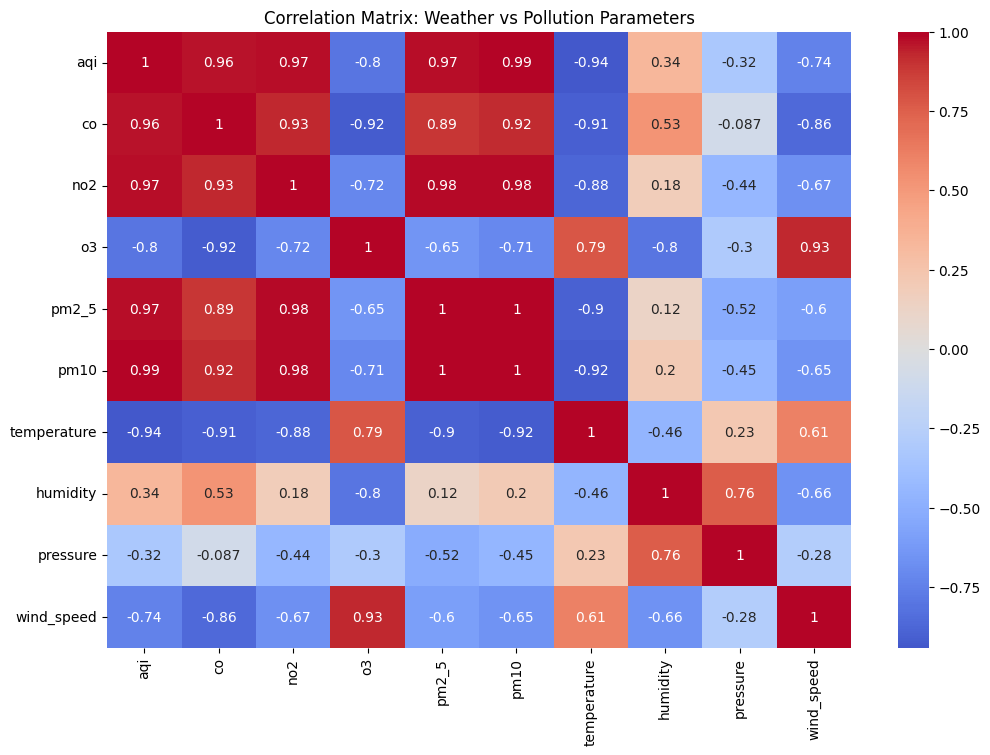

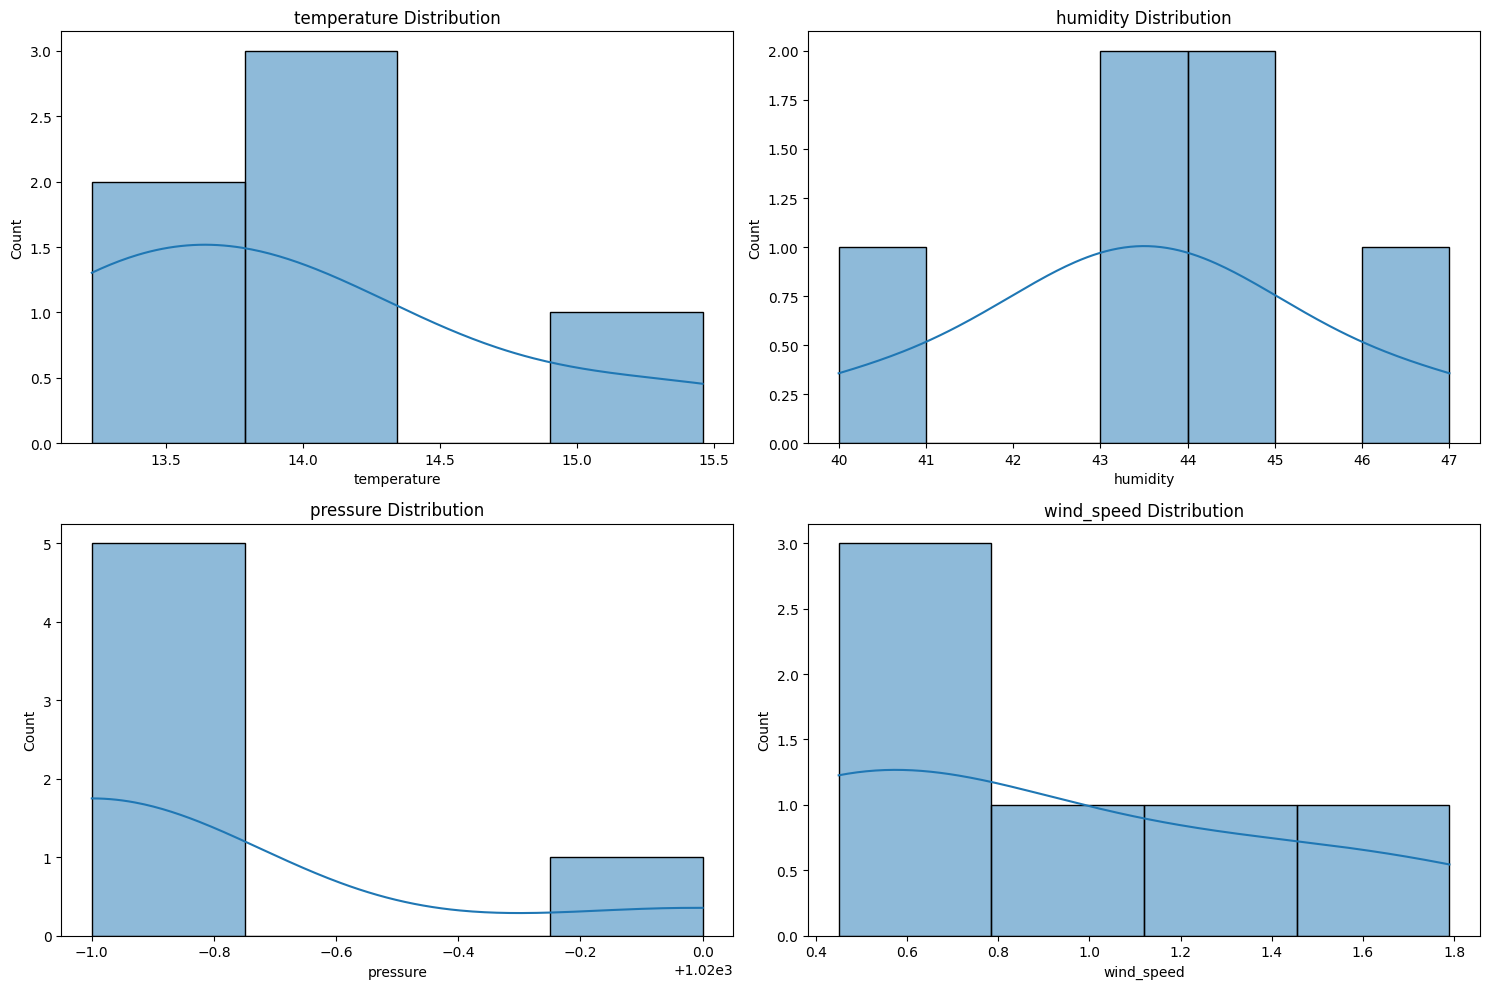

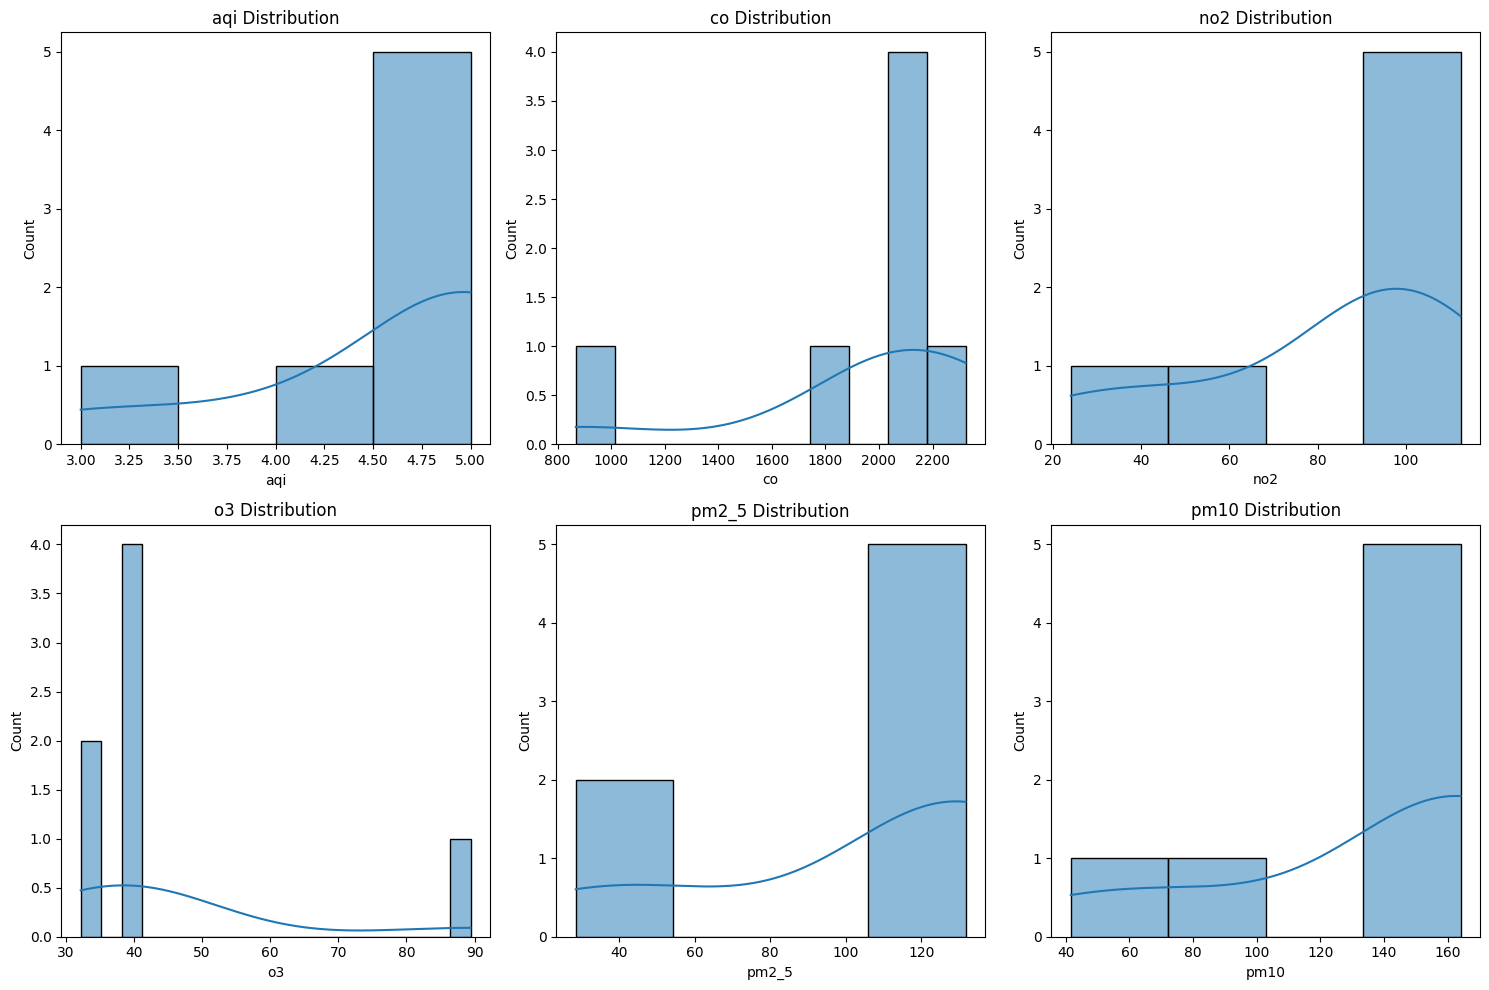

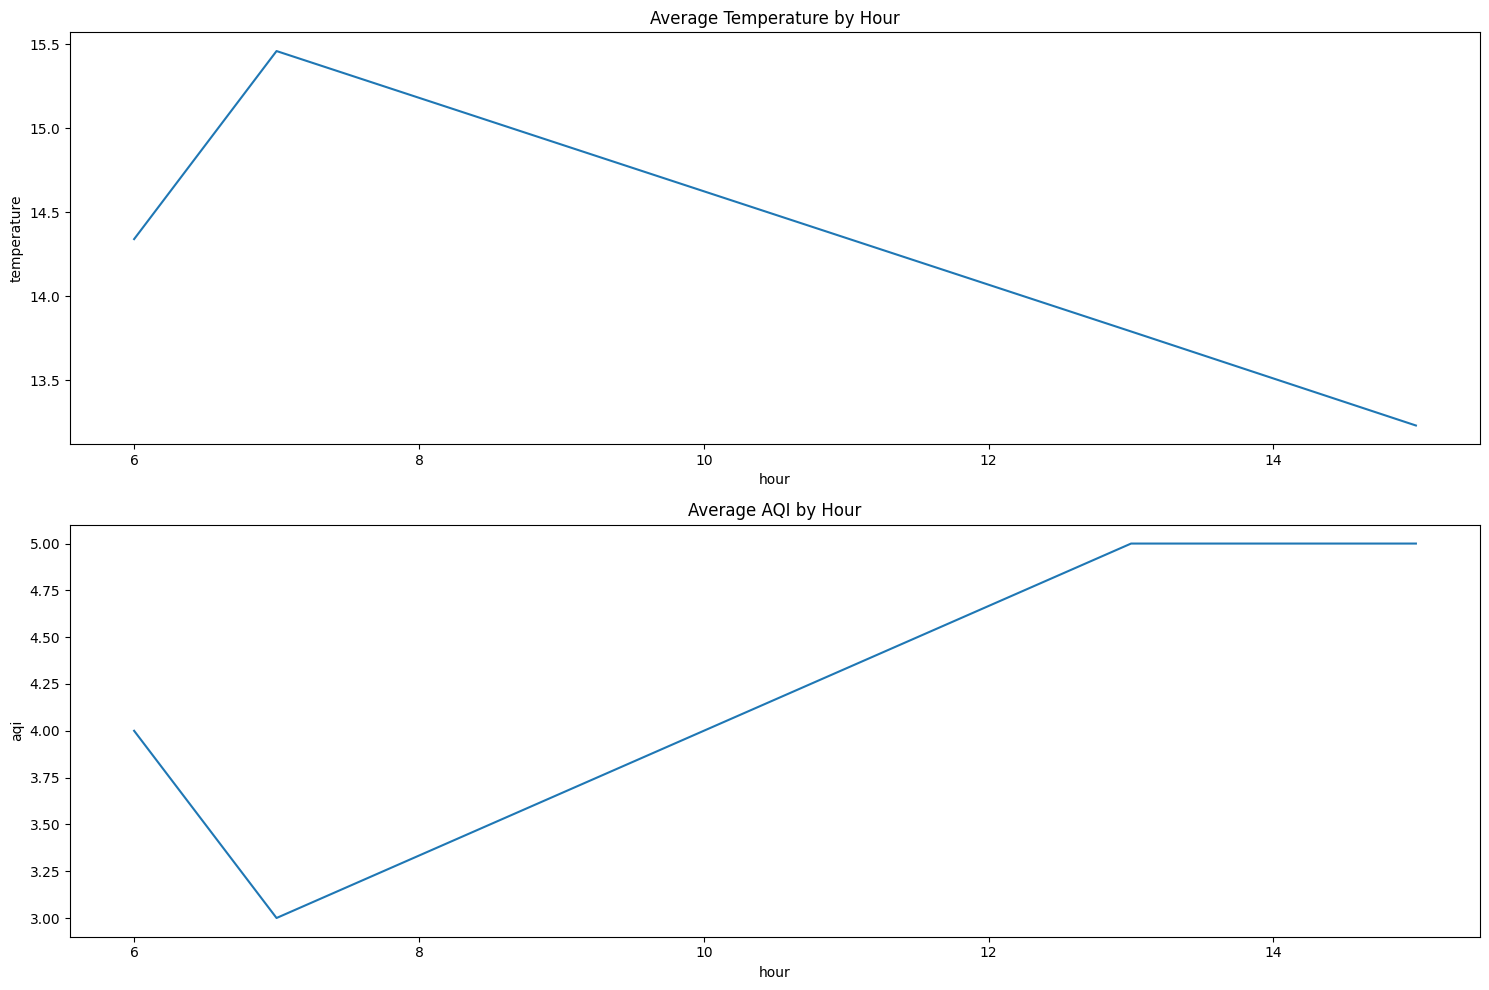

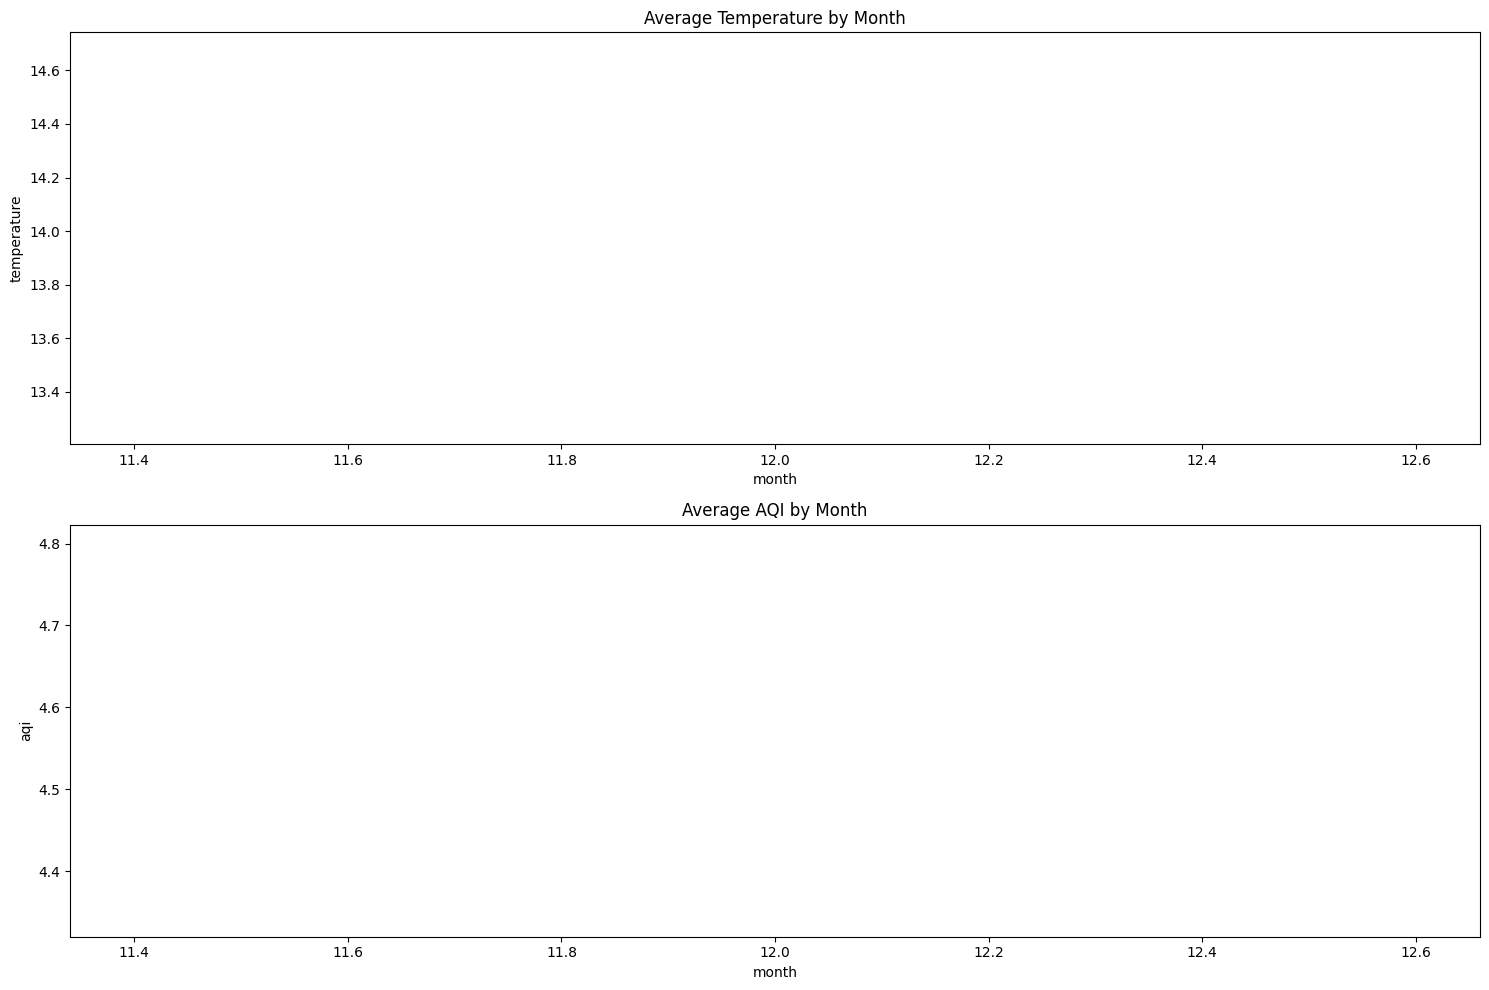

Missing Values in Weather Data:
city                 0
timestamp            0
temperature          0
humidity             0
pressure             0
wind_speed           0
weather_condition    0
hour                 0
month                0
dtype: int64

Missing Values in Pollution Data:
city         0
timestamp    0
aqi          0
co           0
no2          0
o3           0
pm2_5        0
pm10         0
hour         0
month        0
dtype: int64


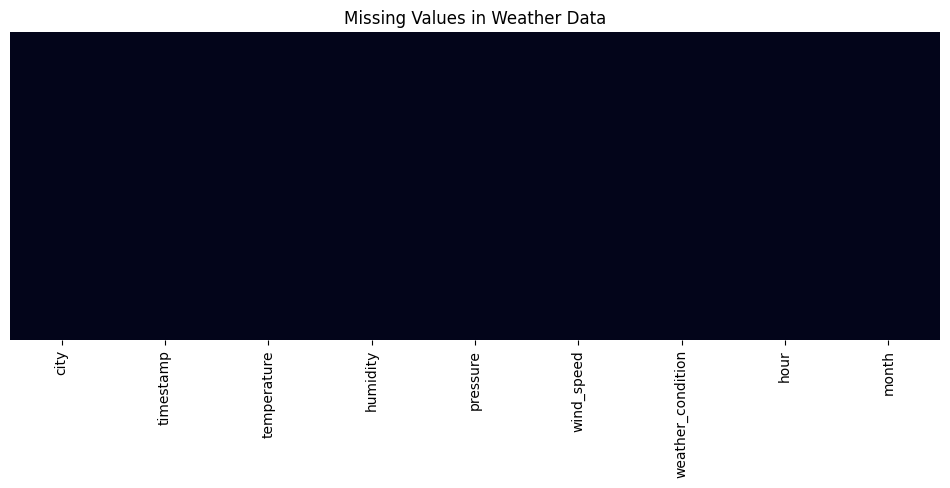

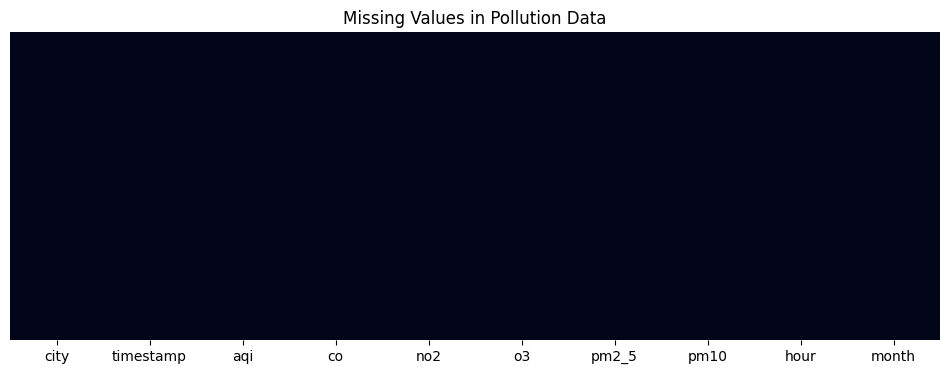

In [16]:
# Main execution
if __name__ == "__main__":
    # Define paths to your data folders
    weather_folder = "E:\\Semester 8\\MLOps\\Project_Task_1\\data\\weather"
    pollution_folder = "E:\\Semester 8\\MLOps\\Project_Task_1\\data\\pollution"
    
    try:
        # Load all data
        weather_df, pollution_df = load_all_data(weather_folder, pollution_folder)
        
        # Check for data continuity
        print("\nChecking data continuity...")
        print("\nWeather Data:")
        print(f"Date range: {weather_df['timestamp'].min()} to {weather_df['timestamp'].max()}")
        print(f"Number of unique dates: {weather_df['timestamp'].dt.date.nunique()}")
        
        print("\nPollution Data:")
        print(f"Date range: {pollution_df['timestamp'].min()} to {pollution_df['timestamp'].max()}")
        print(f"Number of unique dates: {pollution_df['timestamp'].dt.date.nunique()}")
        
        # Run all analyses (using the functions from your original code)
        basic_analysis(weather_df, pollution_df)
        time_series_analysis(weather_df, pollution_df)
        correlation_analysis(weather_df, pollution_df)
        distribution_analysis(weather_df, pollution_df)
        seasonal_analysis(weather_df, pollution_df)
        missing_value_analysis(weather_df, pollution_df)
        
    except Exception as e:
        print(f"An error occurred: {e}")